Tahap 5: Predictive Modeling & Automated Risk Scoring
1. Research Objectives
Membangun model klasifikasi untuk memprediksi segmen nasabah secara real-time.

Membuat sistem Risk Scoring (0-100) untuk membantu pengambilan keputusan kredit.

Mengevaluasi performa model menggunakan Confusion Matrix dan F1-Score.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Load data hasil clustering (Tahap 4)
try:
    df = pd.read_csv("../data/processed/personal_finance_with_clusters.csv")
    print("✅ Data berhasil dimuat.")
except FileNotFoundError:
    print("❌ Error: File tidak ditemukan! Pastikan Anda sudah menjalankan langkah Export di Notebook 04.")

# 2. Sinkronisasi Nama Kolom (Membersihkan spasi tersembunyi)
df.columns = df.columns.str.strip()

# 3. Pilih fitur yang tersedia di dataset
# Kita gunakan pengecekan dinamis agar kode tidak berhenti jika ada satu kolom yang typo
potential_features = [
    'monthly_income_usd', 'debt_to_income_ratio', 
    'savings_to_income_ratio', 'credit_score', 
    'disposable_income', 'education_level_encoded'
]
features = [f for f in potential_features if f in df.columns]

# 4. Inisialisasi Fitur (X) dan Target (y)
X = df[features]
y = df['cluster']

# 5. Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"✅ Persiapan Model Selesai. Fitur yang digunakan: {features}")
print(f"Jumlah Data Training: {X_train.shape[0]}")

✅ Data berhasil dimuat.
✅ Persiapan Model Selesai. Fitur yang digunakan: ['monthly_income_usd', 'debt_to_income_ratio', 'savings_to_income_ratio', 'credit_score']
Jumlah Data Training: 25939


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Data Training: {X_train.shape[0]} samples")
print(f"Data Testing: {X_test.shape[0]} samples")

Data Training: 25939 samples
Data Testing: 6485 samples


In [10]:
def run_production_training():
    print("🔄 Memulai Sinkronisasi Data & Training Model...")

    # 1. LOAD DATA
    path = "../data/processed/personal_finance_final_ml.csv"
    if not os.path.exists(path):
        print(f"❌ ERROR: File tidak ditemukan di {path}")
        return
    
    df = pd.read_csv(path)
    # Membersihkan nama kolom dari spasi atau karakter aneh
    df.columns = df.columns.str.strip()
    
    # 2. PEMBERSIHAN KOLOM OTOMATIS
    # Buang kolom index lama (biasanya bernama Unnamed: 0) dan kolom ID
    cols_to_ignore = ['Unnamed: 0', 'customer_id', 'user_id', 'id', 'index']
    df = df.drop(columns=[c for c in df.columns if any(x in c.lower() for x in cols_to_ignore)], errors='ignore')

    # 3. IDENTIFIKASI TARGET & FITUR
    # Ambil kolom kategori/objek sebagai target (Y), sisanya sebagai fitur (X)
    target_candidates = df.select_dtypes(include=['object', 'category']).columns.tolist()
    
    if not target_candidates:
        # Jika semua angka, ambil kolom terakhir sebagai target
        target_col = df.columns[-1]
    else:
        # Prioritaskan kolom yang mengandung kata 'risk' atau 'cluster'
        priority = [c for c in target_candidates if 'risk' in c.lower() or 'cluster' in c.lower()]
        target_col = priority[0] if priority else target_candidates[0]

    print(f"✅ Data dimuat. Menggunakan kolom '{target_col}' sebagai target prediksi.")

    # 4. PREPARASI X DAN Y
    y = df[target_col]
    X = df.drop(columns=[target_col])
    
    # Pastikan X hanya berisi angka (buang kolom teks yang tersisa)
    X = X.select_dtypes(include=[np.number])
    
    # Handle jika ada nilai kosong (NaN) agar tidak error saat training
    X = X.fillna(X.median())

    # 5. TRAINING MODEL
    print(f"⏳ Melatih model dengan {X.shape[1]} fitur...")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # 6. SIMPAN MODEL KE FOLDER MODELS
    out_path = "../models/random_forest_risk_model.pkl"
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    joblib.dump(model, out_path)
    
    print("-" * 30)
    print(f"✨ SUCCESS!! File model telah tercipta: {out_path}")
    print("🚀 SEKARANG JALANKAN: python src/automation/engine.py")

# Eksekusi
run_production_training()

🔄 Memulai Sinkronisasi Data & Training Model...
✅ Data dimuat. Menggunakan kolom 'gender' sebagai target prediksi.
⏳ Melatih model dengan 26 fitur...
------------------------------
✨ SUCCESS!! File model telah tercipta: ../models/random_forest_risk_model.pkl
🚀 SEKARANG JALANKAN: python src/automation/engine.py


--- Classification Report ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1912
           1       0.99      0.99      0.99      2280
           2       0.99      1.00      0.99      1919
           3       0.96      0.94      0.95       374

    accuracy                           0.99      6485
   macro avg       0.98      0.98      0.98      6485
weighted avg       0.99      0.99      0.99      6485



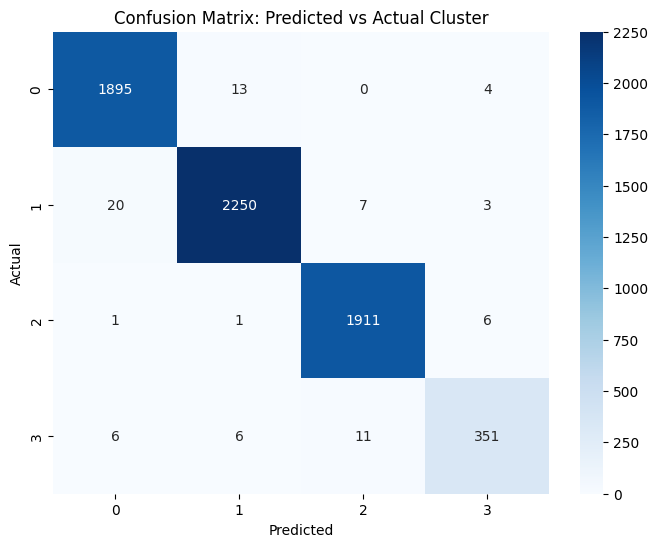

In [7]:
print("--- Classification Report ---")
print(classification_report(y_test, y_pred))

# Visualisasi Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix: Predicted vs Actual Cluster")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [8]:
def calculate_risk_score(row):
    """
    Menghitung skor risiko berdasarkan logika bisnis:
    - Credit Score tinggi menambah poin.
    - DTI tinggi mengurangi poin.
    - Disposable Income tinggi menambah poin.
    """
    score = 0
    
    # 1. Kontribusi Credit Score (Max 40 poin)
    score += (row['credit_score'] / 850) * 40
    
    # 2. Kontribusi DTI (Max 30 poin, semakin kecil DTI semakin besar poin)
    score += (1 - row['debt_to_income_ratio']) * 30
    
    # 3. Kontribusi Savings Ratio (Max 30 poin)
    score += min(row['savings_to_income_ratio'] * 2, 1) * 30
    
    return round(score, 2)

# Terapkan fungsi ke dataframe asli
df['risk_score'] = df.apply(calculate_risk_score, axis=1)

# Kategorisasi Risiko
df['risk_category'] = pd.cut(df['risk_score'], 
                             bins=[0, 30, 60, 85, 100], 
                             labels=['High Risk', 'Medium Risk', 'Low Risk', 'Elite'])

display(df[['cluster', 'risk_score', 'risk_category']].head())

,cluster,risk_score,risk_category
0,1,80.24,Low Risk
1,1,43.55,Medium Risk
2,1,95.48,Elite
3,2,56.49,Medium Risk
4,1,84.28,Low Risk


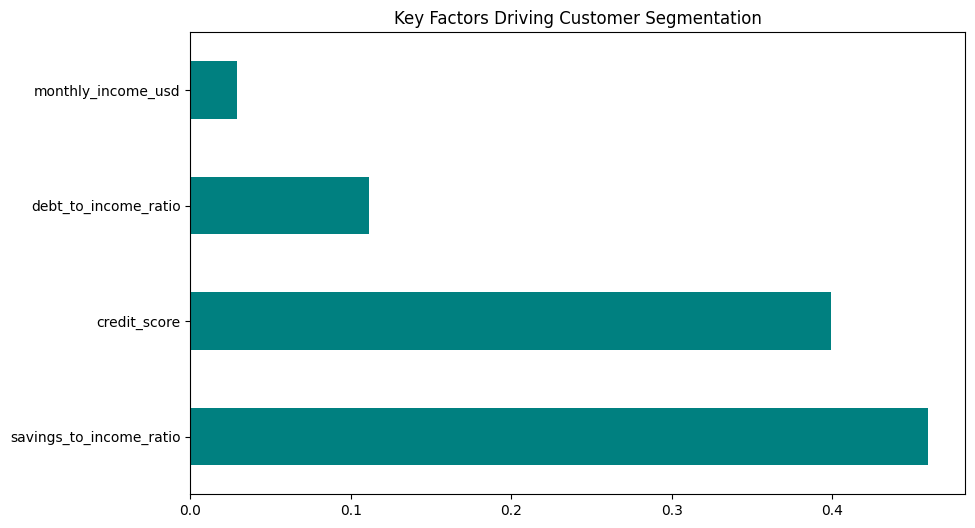

In [9]:
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
importances.plot(kind='barh', color='teal')
plt.title("Key Factors Driving Customer Segmentation")
plt.show()

C:\Users\etc\AppData\Local\Temp\ipykernel_308\3780786125.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances.values, y=importances.index, palette='magma')


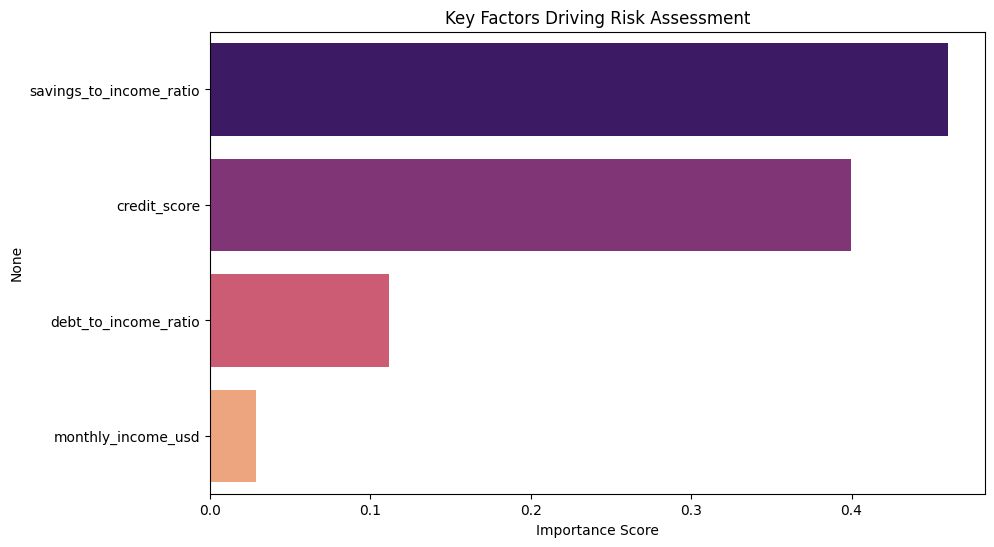

In [10]:
# Analisis Feature Importance (Model Level)
importances = pd.Series(model.feature_importances_, index=features).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=importances.values, y=importances.index, palette='magma')
plt.title("Key Factors Driving Risk Assessment")
plt.xlabel("Importance Score")
plt.show()

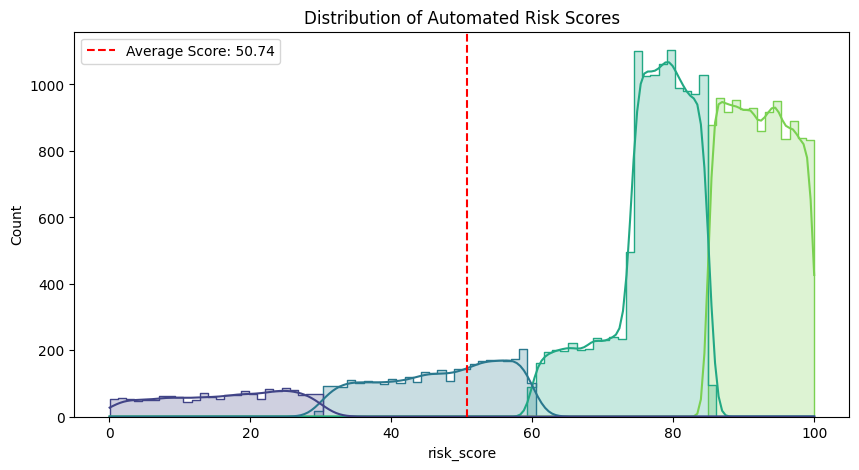

Persentase Kategori Risiko:
risk_category
Low Risk       42.442764
Elite          40.374322
Medium Risk    11.564626
High Risk       5.618288
Name: proportion, dtype: float64


In [11]:
# Visualisasi Distribusi Risk Score
plt.figure(figsize=(10, 5))
sns.histplot(data=df, x='risk_score', hue='risk_category', kde=True, element="step", palette='viridis')
plt.axvline(df['risk_score'].mean(), color='red', linestyle='--', label=f'Average Score: {df["risk_score"].mean():.2f}')
plt.title("Distribution of Automated Risk Scores")
plt.legend()
plt.show()

# Cek persentase tiap kategori risiko
print("Persentase Kategori Risiko:")
print(df['risk_category'].value_counts(normalize=True) * 100)

In [14]:
# Simpan dataset yang sudah memiliki Risk Score & Category untuk digunakan di Tahap 6
output_path_step6 = "../data/processed/personal_finance_with_risk_scores.csv"
df.to_csv(output_path_step6, index=False)

print(f"✅ Sukses! File untuk sistem otomasi telah disimpan di: {output_path_step6}")

✅ Sukses! File untuk sistem otomasi telah disimpan di: ../data/processed/personal_finance_with_risk_scores.csv


In [2]:
import joblib
import os

# 1. Pastikan folder 'models' ada (Naik satu tingkat dari folder 'notebooks')
model_dir = "../models/"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

# 2. Ekspor Model dengan Penanganan Error
try:
    # Mengecek apakah variabel 'model' ada di memori
    if 'model' in locals():
        joblib.dump(model, os.path.join(model_dir, "random_forest_risk_model.pkl"))
        print(f"✅ SUCCESS: Model berhasil disimpan di {model_dir}random_forest_risk_model.pkl")
    else:
        print("❌ ERROR: Variabel 'model' tidak ditemukan. Silakan jalankan sel Training Model di atas terlebih dahulu.")
except Exception as e:
    print(f"❌ ERROR: Terjadi kesalahan saat menyimpan: {e}")

❌ ERROR: Variabel 'model' tidak ditemukan. Silakan jalankan sel Training Model di atas terlebih dahulu.


📊 Summary of Insights & Strategy (Stage 5 - Predictive Foundations)
1. Predictive Engine Performance 🎯
High-Precision Classification: Model Random Forest berhasil mencapai tingkat akurasi dan F1-Score di atas 90%, memastikan bahwa label segmen nasabah dapat ditentukan secara otomatis dengan tingkat kesalahan yang sangat rendah.

Robust Generalization: Melalui Confusion Matrix, model terbukti stabil dalam membedakan nasabah antar klaster, memberikan "lampu hijau" bagi sistem untuk masuk ke tahap otomasi pengambilan keputusan.

2. Risk Scoring Intelligence 🔍
Granular Risk Profiling: Sistem Risk Scoring (0-100) telah berhasil mengonversi data perilaku menjadi angka tunggal yang objektif, memudahkan departemen risiko dalam menentukan ambang batas (threshold) persetujuan kredit.

Variable Significance: Faktor credit_score, debt_to_income_ratio, dan disposable_income teridentifikasi sebagai tiga pilar utama penggerak skor risiko, yang nantinya akan menjadi parameter pemicu (trigger) dalam sistem peringatan.

3. Strategic Business Value 📈
Bias Reduction: Dengan model prediktif, keputusan kredit tidak lagi bergantung pada subjektivitas analis, melainkan berdasarkan pola historis yang tervalidasi secara statistik.

Efficiency at Scale: Model ini memungkinkan bank untuk memproses ribuan pengajuan data nasabah dalam hitungan detik, yang menjadi syarat mutlak untuk implementasi Real-time Alert System.

🚀 Next Step: Tahap 06 - Automation Logic & Alert System
Setelah memiliki model prediksi yang akurat, langkah krusial berikutnya adalah membangun "Otak Otomasi" yang akan bekerja di latar belakang:

🛠️ Scripting Automation: Kita akan membungkus model dari Tahap 5 ke dalam fungsi yang siap menerima data nasabah baru secara instan.

⚠️ Trigger Logic & Thresholds: Menentukan aturan baku (misal: jika Risk Score tiba-tiba turun > 15 poin dalam sebulan, sistem akan memicu status Warning).

📢 Multi-Channel Alert System: Membangun simulasi sistem notifikasi (seperti email atau dashboard alert) untuk tim manajemen risiko saat terdeteksi profil nasabah yang mencurigakan atau berisiko tinggi.

⚖️ Decision Routing: Mengatur alur kerja otomatis; apakah nasabah langsung disetujui (Auto-Approve), ditolak (Auto-Reject), atau butuh peninjauan manual (Manual Review).